In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.datasets import load_breast_cancer, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS = []

# 1. Model

class DynamicAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(DynamicAutoencoder, self).__init__()
        # Dynamic architecture based on input size
        if input_dim <= 50: # low dim (biological)
            hidden_dim = 16
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, input_dim)
            )
        elif input_dim <= 1000: # medium dim (image)
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 128), nn.ReLU(),
                nn.Linear(128, 256), nn.ReLU(),
                nn.Linear(256, input_dim), nn.Sigmoid()
            )
        else: # high dim (text)
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 512), nn.ReLU(),
                nn.Dropout(0.2), # dropout for sparsity
                nn.Linear(512, 128), nn.ReLU(),
                nn.Linear(128, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 128), nn.ReLU(),
                nn.Linear(128, 512), nn.ReLU(),
                nn.Linear(512, input_dim), nn.Sigmoid()
            )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(X_train, input_dim, latent_dim, epochs=20, batch_size=64):
    model = DynamicAutoencoder(input_dim, latent_dim).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    dataset = TensorDataset(torch.from_numpy(X_train).float())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        for (batch_x,) in loader:
            batch_x = batch_x.to(DEVICE)
            optimizer.zero_grad()
            output, _ = model(batch_x)
            loss = criterion(output, batch_x)
            loss.backward()
            optimizer.step()
    
    train_time = time.time() - start_time
    
    # Extract Latent Features
    model.eval()
    with torch.no_grad():
        z_train = model.encoder(torch.from_numpy(X_train).float().to(DEVICE)).cpu().numpy()
        
    return z_train, model, train_time

In [3]:
# 2. Trainer Function

def run_experiment(dataset_name, X_train, X_test, y_train, y_test, latent_grids, knn_grid, dae_epochs=30):
    input_dim = X_train.shape[1]
    print(f"\n>>> Processing {dataset_name} (Input Dim: {input_dim})")
    
    # Method 1: PCA
    # fit PCA once with the max dimension, then slice it for smaller grids to save time
    max_k = max(latent_grids)
    print(f"   [PCA] Fitting max components ({max_k})...")
    
    start_pca = time.time()
    if input_dim > 1000 and np.min(X_train) >= 0: # Use TruncatedSVD for sparse/text-like
        pca = TruncatedSVD(n_components=max_k, random_state=42)
    else:
        pca = PCA(n_components=max_k, random_state=42)
        
    Z_train_pca_full = pca.fit_transform(X_train)
    Z_test_pca_full = pca.transform(X_test)
    pca_fit_time = time.time() - start_pca
    
    # iterate over latent dimensions (PCA)
    for k in latent_grids:
        # slice the pre-computed PCA
        Z_train_k = Z_train_pca_full[:, :k]
        Z_test_k = Z_test_pca_full[:, :k]
        
        # grid search for kNN
        knn = KNeighborsClassifier()
        clf = GridSearchCV(knn, knn_grid, cv=3, n_jobs=-1)
        clf.fit(Z_train_k, y_train)
        
        acc = clf.score(Z_test_k, y_test)
        
        RESULTS.append({
            "Dataset": dataset_name,
            "Method": "PCA",
            "Latent_Dim": k,
            "Best_KNN_K": clf.best_params_['n_neighbors'],
            "Accuracy": acc,
            "Time (s)": pca_fit_time
        })
        print(f"   [PCA] k={k}: Acc={acc:.4f} (Best KNN={clf.best_params_['n_neighbors']})")

    # Method 2: DAE
    for k in latent_grids:
        print(f"   [DAE] Training for latent dim k={k}...")

        Z_train_ae, model, ae_time = train_autoencoder(X_train, input_dim, k, epochs=dae_epochs)

        # encode test set
        model.eval()
        with torch.no_grad():
            Z_test_ae = model.encoder(torch.from_numpy(X_test).float().to(DEVICE)).cpu().numpy()

        # grid search for kNN
        knn = KNeighborsClassifier()
        clf = GridSearchCV(knn, knn_grid, cv=3, n_jobs=-1)
        clf.fit(Z_train_ae, y_train)
        
        acc = clf.score(Z_test_ae, y_test)
        
        RESULTS.append({
            "Dataset": dataset_name,
            "Method": "DAE",
            "Latent_Dim": k,
            "Best_KNN_K": clf.best_params_['n_neighbors'],
            "Accuracy": acc,
            "Time (s)": ae_time
        })
        print(f"   [DAE] k={k}: Acc={acc:.4f} (Best KNN={clf.best_params_['n_neighbors']}) | Time={ae_time:.2f}s")

In [4]:
# 3. Load Datasets and Run Experiments

# Dataset 1: Breast Cancer
data_bc = load_breast_cancer()
X_bc = StandardScaler().fit_transform(data_bc.data)
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, data_bc.target, test_size=0.2, random_state=42)

run_experiment(
    "Breast Cancer (Low Dim)", 
    X_train_bc, X_test_bc, y_train_bc, y_test_bc, 
    latent_grids=[2, 5, 10],   # search space for latent dim
    knn_grid={'n_neighbors': [3, 5, 9]} # search space for kNN
)

# Dataset 2: KMNIST

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
print("\nLoaded KMNIST.")

# Flatten
X_train_km = train_set.data.numpy().reshape(-1, 784).astype('float32') / 255.0
X_test_km = test_set.data.numpy().reshape(-1, 784).astype('float32') / 255.0
y_train_km = train_set.targets.numpy()
y_test_km = test_set.targets.numpy()

run_experiment(
    "KMNIST (Medium Dim)", 
    X_train_km, X_test_km, y_train_km, y_test_km, 
    latent_grids=[10, 30, 64],  # upper bound roughly 10% of input
    knn_grid={'n_neighbors': [3, 5, 9]}
)

# Dataset 3: 20 Newsgroups
print("\nFetching 20 Newsgroups...")
categories = ['sci.med', 'sci.space', 'comp.graphics', 'rec.autos']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_news = vectorizer.fit_transform(newsgroups.data).toarray() # dense for PyTorch compatibility
y_news = newsgroups.target

# Scale (MaxAbs is best for sparse, but we made it dense so standard/minmax works)
X_news = MaxAbsScaler().fit_transform(X_news)
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news, y_news, test_size=0.2, random_state=42)

run_experiment(
    "20 Newsgroups (High Dim)", 
    X_train_news, X_test_news, y_train_news, y_test_news, 
    latent_grids=[10, 50, 100], 
    knn_grid={'n_neighbors': [5, 15]}
)


>>> Processing Breast Cancer (Low Dim) (Input Dim: 30)
   [PCA] Fitting max components (10)...
   [PCA] k=2: Acc=0.9737 (Best KNN=5)
   [PCA] k=5: Acc=0.9649 (Best KNN=9)
   [PCA] k=10: Acc=0.9474 (Best KNN=3)
   [DAE] Training for latent dim k=2...
   [DAE] k=2: Acc=0.9912 (Best KNN=5) | Time=0.12s
   [DAE] Training for latent dim k=5...
   [DAE] k=5: Acc=0.9298 (Best KNN=3) | Time=0.06s
   [DAE] Training for latent dim k=10...
   [DAE] k=10: Acc=0.9649 (Best KNN=9) | Time=0.06s

Loaded KMNIST.

>>> Processing KMNIST (Medium Dim) (Input Dim: 784)
   [PCA] Fitting max components (64)...
   [PCA] k=10: Acc=0.7865 (Best KNN=9)
   [PCA] k=30: Acc=0.9195 (Best KNN=5)
   [PCA] k=64: Acc=0.9337 (Best KNN=3)
   [DAE] Training for latent dim k=10...
   [DAE] k=10: Acc=0.8753 (Best KNN=5) | Time=44.40s
   [DAE] Training for latent dim k=30...
   [DAE] k=30: Acc=0.9346 (Best KNN=5) | Time=49.21s
   [DAE] Training for latent dim k=64...
   [DAE] k=64: Acc=0.9398 (Best KNN=3) | Time=56.20s

Fetch

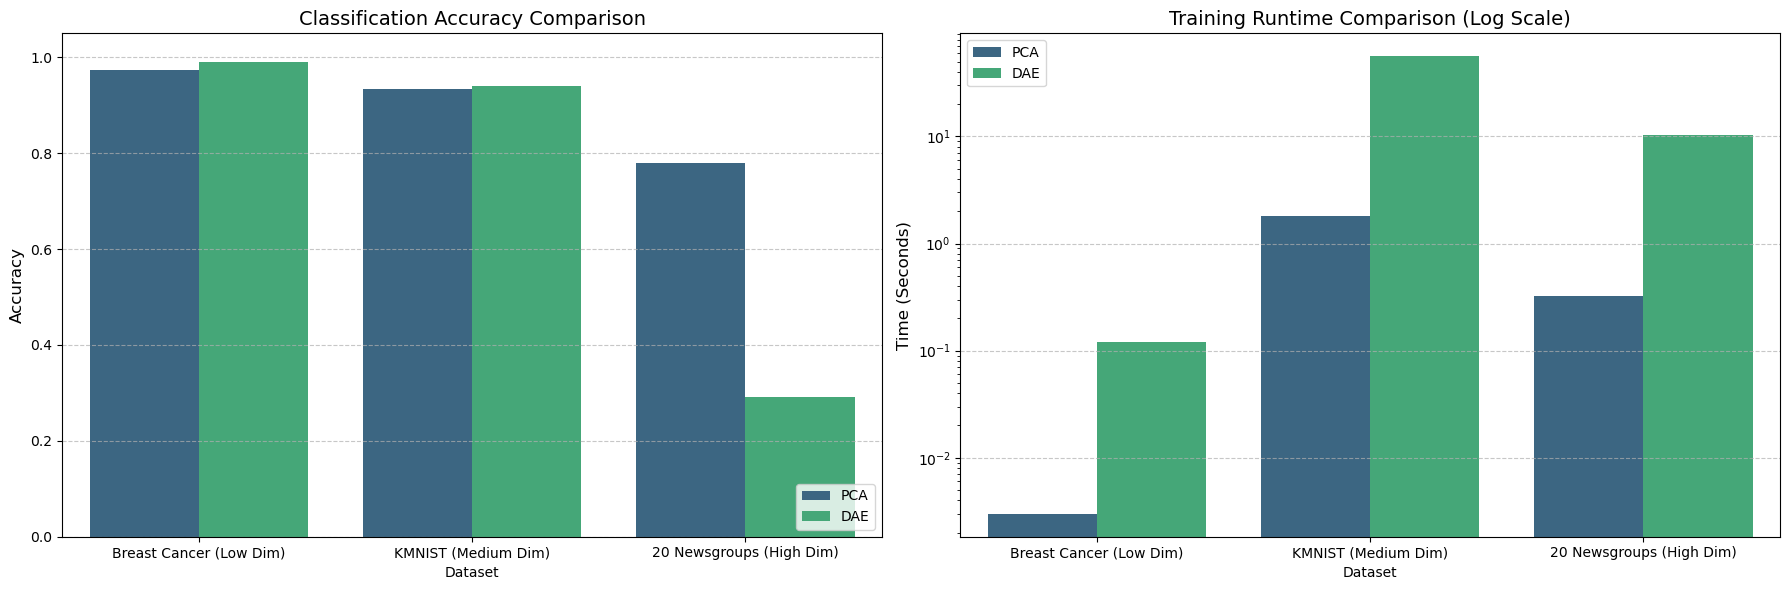

In [5]:
# 4. Plotting

import matplotlib.pyplot as plt
import seaborn as sns

# ensure the results are in a DataFrame
df_results = pd.DataFrame(RESULTS)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Classification Accuracy
sns.barplot(
    data=df_results, 
    x='Dataset', 
    y='Accuracy', 
    hue='Method', 
    estimator=max, # Show best accuracy per method
    errorbar=None, # Removes confidence intervals for cleaner look
    ax=axes[0], 
    palette="viridis"
)
axes[0].set_title("Classification Accuracy Comparison", fontsize=14)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(loc='lower right')

# Plot 2: Training Runtime (Log Scale)
sns.barplot(
    data=df_results, 
    x='Dataset', 
    y='Time (s)', 
    hue='Method', 
    estimator=max, # Show max time per method
    errorbar=None, 
    ax=axes[1], 
    palette="viridis"
)
axes[1].set_title("Training Runtime Comparison (Log Scale)", fontsize=14)
axes[1].set_ylabel("Time (Seconds)", fontsize=12)
axes[1].set_yscale("log") 
axes[1].grid(axis='y', linestyle='--', alpha=0.7, which="major")
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.savefig("./figs/exp_1_comp.pdf", dpi=300)
plt.show()

In [6]:
df_results

,Dataset,Method,Latent_Dim,Best_KNN_K,Accuracy,Time (s)
0,Breast Cancer (Low Dim),PCA,2,5,0.973684,0.002991
1,Breast Cancer (Low Dim),PCA,5,9,0.964912,0.002991
2,Breast Cancer (Low Dim),PCA,10,3,0.947368,0.002991
3,Breast Cancer (Low Dim),DAE,2,5,0.991228,0.120818
4,Breast Cancer (Low Dim),DAE,5,3,0.929825,0.060756
5,Breast Cancer (Low Dim),DAE,10,9,0.964912,0.062077
6,KMNIST (Medium Dim),PCA,10,9,0.786500,1.790830
7,KMNIST (Medium Dim),PCA,30,5,0.919500,1.790830
8,KMNIST (Medium Dim),PCA,64,3,0.933700,1.790830
9,KMNIST (Medium Dim),DAE,10,5,0.875300,44.401978


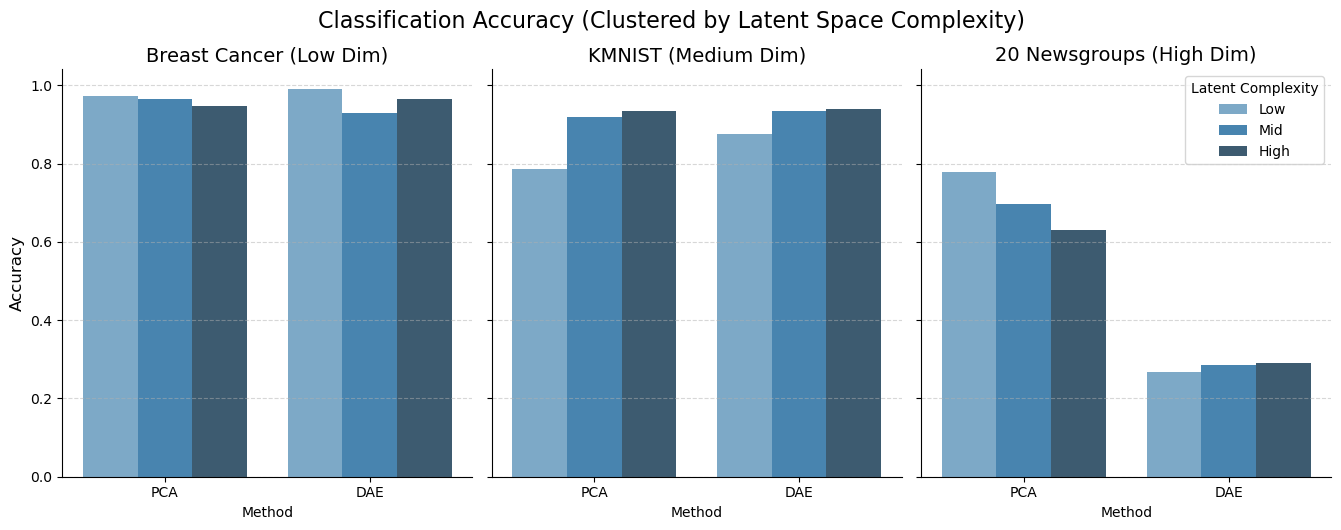

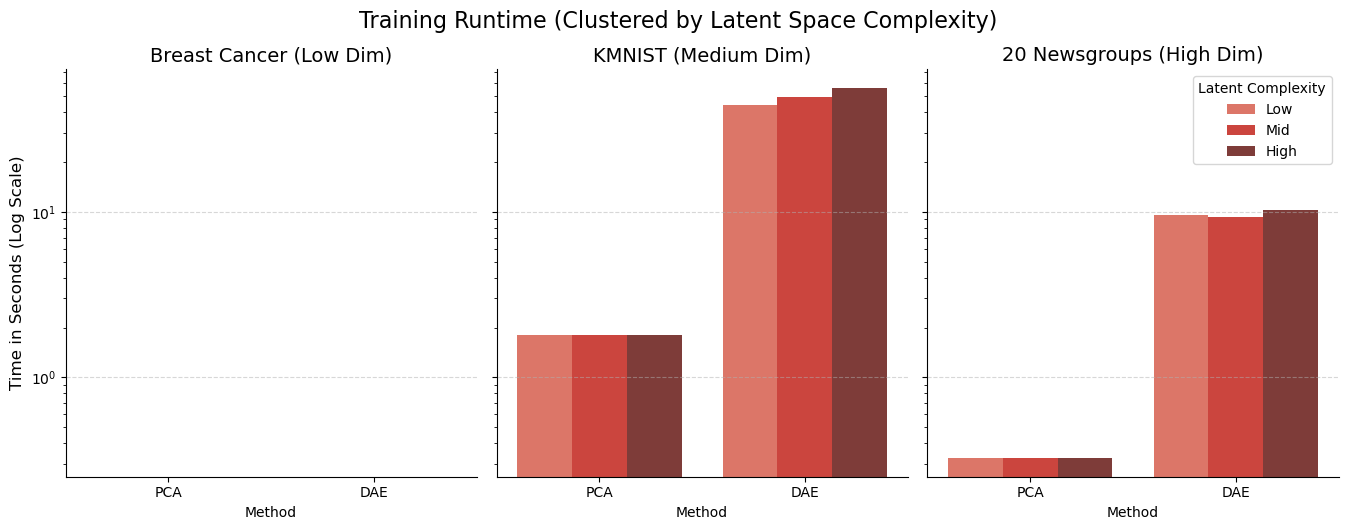

In [7]:
# Plot 3: Detailed Plots Clustered by Latent Space Complexity

# 1. Map latent dims to "Low/Mid/High"
def assign_rank(group):
    # Sort unique k values for this specific dataset
    unique_k = sorted(group['Latent_Dim'].unique())
    # Create a mapping: smallest k -> "Low", medium -> "Mid", largest -> "High"
    labels = ["Low", "Mid", "High"]
    k_map = {k: labels[i] for i, k in enumerate(unique_k)}
    return group['Latent_Dim'].map(k_map)

# Apply this mapping per dataset
df_results['Complexity'] = df_results.groupby('Dataset', group_keys=False).apply(assign_rank)

# Define a specific order for plotting so "Low" is always left
complexity_order = ["Low", "Mid", "High"]

# 2. Plot accuracy
g1 = sns.catplot(
    data=df_results, 
    kind="bar", 
    x="Method", 
    y="Accuracy", 
    hue="Complexity", 
    hue_order=complexity_order,
    col="Dataset", 
    col_wrap=3,
    sharex=False,
    height=5, 
    aspect=0.9,
    palette="Blues_d",
    legend=False 
)

g1.fig.suptitle("Classification Accuracy (Clustered by Latent Space Complexity)", y=1.05, fontsize=16)
g1.set_titles("{col_name}", size=14)
g1.set_ylabels("Accuracy", fontsize=12)

# Add gridlines
for ax in g1.axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title="Latent Complexity", loc='upper right')
plt.savefig("./figs/exp_1_comp_clus_med.pdf", dpi=300)
plt.show()

# 3. Plot runtime
g2 = sns.catplot(
    data=df_results, 
    kind="bar", 
    x="Method", 
    y="Time (s)", 
    hue="Complexity", 
    hue_order=complexity_order,
    col="Dataset", 
    col_wrap=3,
    sharex=False,
    height=5, 
    aspect=0.9,
    palette="Reds_d",
    legend=False
)

g2.fig.suptitle("Training Runtime (Clustered by Latent Space Complexity)", y=1.05, fontsize=16)
g2.set(yscale="log") # Log scale
g2.set_titles("{col_name}", size=14)
g2.set_ylabels("Time in Seconds (Log Scale)", fontsize=12)

for ax in g2.axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.5, which="major")

plt.legend(title="Latent Complexity", loc='upper right')
plt.show()